# <font color='yellow'>Projet machine learning : prédire le prix d'une maison</font>

## Algorithme utilisé pour la prédiction : régression linéaire multiple.

In [137]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
import math

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.compat import lzip
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import t, shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_union, make_pipeline

Le jeu de données contient les prix de vente des maisons dans la région de Seattle. Des informations de nature temporelle, géographique, de qualité, etc. sont ajoutées pour chaque vente ce qui nous permet de construire un modèle prédictif. Ci-dessous la signification de chacune des colonnes du jeu de données.

<!-- ![title](dataset_columns_explanation.png) -->
<center><img src="./images/dataset_columns_explanation.png"/></center>

## <font color='green'>Transformation de features</font>

### Fonctions pour la création, la transformation et la suppression de features dans les jeux d'entraînement et de test

On définit les fonctions qui permettent de construire ces nouvelles features, on prend bien soin de ne pas polluer le dataset de test avec des informations du jeu d'entraînement.

In [138]:
def convert_date(df):
    df['date'] = pd.to_datetime(df['date']) - pd.to_datetime(df['date']).min()
    df['date'] = df['date'].dt.days

def waterfront_view(df):
    df['waterfront_view'] = df['waterfront'] + df['view']

def create_yr_combined(df):
    yr_combined = df['yr_built'].copy()
    yr_renovated = df[df['yr_renovated'] != 0]['yr_renovated'].reset_index()
    index = yr_renovated['index']
    yr = yr_renovated['yr_renovated']
    for i in range(0,len(index)):
        yr_combined[index[i]] = yr[i]
    df['yr_combined'] = yr_combined
    
def encode_yr(df):
    df['yr_encoded'] = df['yr_combined']
    df.loc[df['yr_combined'] < 1940, 'yr_encoded'] = 1
    df.loc[(df['yr_combined'] >= 1940) & (df['yr_combined'] < 1980), 'yr_encoded'] = 0
    df.loc[(df['yr_combined'] >= 1980), 'yr_encoded'] = 1

def encode_lat(df):
    df['lat_encoded'] = df['lat']
    df.loc[df['lat'] < 47.26, 'lat_encoded'] = int(1)
    df.loc[(df['lat'] >= 47.26) & (df['lat'] < 47.50), 'lat_encoded'] = int(0)
    df.loc[(df['lat'] >= 47.50) & (df['lat'] < 47.54), 'lat_encoded'] = int(1)
    df.loc[(df['lat'] >= 47.54) & (df['lat'] < 47.68), 'lat_encoded'] = int(2)
    df.loc[df['lat'] >= 47.68, 'lat_encoded'] = int(1)

def reorganize_zipcode(df,X):
    zipcodes = df['zipcode'].sort_values().unique()
    price_zipcodes = [df[df['zipcode'] == zipcode]['price'].mean() for zipcode in zipcodes]
    price_zipcodes, zipcodes = zip(*sorted(zip(price_zipcodes, zipcodes)))
    X['zipcode_new'] = X['zipcode']
    for i, zipcode in enumerate(zipcodes):
        X.loc[X['zipcode'] == zipcode, 'zipcode_new'] = i

## <font color='green'>Modélisation par régression linéaire avec statsmodel et sklearn</font>

## Chargement des données et preprocessing

In [173]:
pd.set_option('display.max_columns', None)
df_all = pd.read_csv("kc_house_data.csv")
y = df_all['price']
# X = df_all.drop('price',axis=1)
X = df_all.drop(['price'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.20, random_state=42)
df = X_train.join(y_train)

convert_date(X_train)
# waterfront_view(X_train)
create_yr_combined(X_train)
# encode_yr(X_train)
# encode_lat(X_train)
# reorganize_zipcode(df, X_train)
# encode_floors(X_train)
# X_train = X_train.drop(['zipcode'], axis=1)
# X_train = X_train.drop(['date'], axis=1)
X_train = X_train.drop(['id', 'sqft_basement','sqft_living15','sqft_lot15'], axis=1)
X_train = X_train.drop(['yr_built','yr_renovated'], axis=1)
# X_train = X_train.drop(['waterfront', 'view'], axis=1)
# X_train = X_train.drop(['floors'], axis=1)

convert_date(X_test)
# waterfront_view(X_test)
create_yr_combined(X_test)
# encode_yr(X_test)
# encode_lat(X_test)
# reorganize_zipcode(df, X_test)
# encode_floors(X_test)
# X_test = X_test.drop(['zipcode'], axis=1)
# X_test = X_test.drop(['date'], axis=1)
X_test = X_test.drop(['id', 'sqft_basement','sqft_living15','sqft_lot15'], axis=1)
X_test= X_test.drop(['yr_built','yr_renovated'], axis=1)
# X_test = X_test.drop(['waterfront', 'view'], axis=1)
# X_test = X_test.drop(['floors'], axis=1)


### Preprocessing

In [174]:
r2_adj = []
mse = []
rmse = []
mae = []
mdae = []

r2_adj_test = []
mse_test = []
rmse_test = []
mae_test = []
mdae_test = []

# sc = RobustScaler()
# ohe = OneHotEncoder()
# poly_features = PolynomialFeatures(degree=2)
# preprocessor = make_pipeline(sc, poly_features)

all_columns_except_zipcode = X_train.drop(['zipcode'],axis=1).columns
zipcode_column = ['zipcode']
all_pipeline = make_pipeline(RobustScaler(), PolynomialFeatures(degree=2))
zipcode_pipeline = make_pipeline(OneHotEncoder())
preprocessor = make_column_transformer((all_pipeline,all_columns_except_zipcode),(zipcode_pipeline, zipcode_column), remainder = 'passthrough')

X_train_new = preprocessor.fit_transform(X_train)
X_test_new = preprocessor.fit_transform(X_test)

X_train_new_df = pd.DataFrame(X_train_new)
y_train = pd.DataFrame(y_train).reset_index().drop(['index'],axis=1)

X_test_new_df = pd.DataFrame(X_test_new)
y_test = pd.DataFrame(y_test).reset_index().drop(['index'],axis=1)

features_name = {}
for i in range(X_train_new.shape[1]):
    # features_name[i] = poly_features.get_feature_names_out()[i].replace(" ","").replace("^","_")
    features_name[i] = preprocessor.get_feature_names_out()[i].replace(" ","").replace("^","_").replace('pipeline-1__','').replace('pipeline-2__','')
X_train_new_df = X_train_new_df.rename(columns=features_name)
X_test_new_df = X_test_new_df.rename(columns=features_name)
df_new = X_train_new_df.join(y_train)

## Nettoyage des données et ajustement statsmodel

In [175]:
formula = 'price ~ '
max = X_train_new.shape[1]
for i in range(0,max):
    if i != max-1:
        # formula += poly_features.get_feature_names_out()[i] + ' + '
        formula += preprocessor.get_feature_names_out()[i] + ' + '
    if i == max-1:
        # formula += poly_features.get_feature_names_out()[i]
        formula += preprocessor.get_feature_names_out()[i]
# formula = formula.replace(" ","").replace("^","_")
formula = formula.replace(" ","").replace("^","_").replace('pipeline-1__','').replace('pipeline-2__','')

In [ ]:
ols_model = smf.ols(formula, data=df_new)
# ols_model = sm.OLS(y_train,X_train_new)
ols_res = ols_model.fit()
print(ols_res.summary())

In [202]:
pvalue = 2
index = ''
features_to_delete = []
while True:
    formula = formula.replace('+' + index + '+', '+')
    ols_model = smf.ols(formula, data=df_new)
    ols_res = ols_model.fit()
    pvalues = ols_res.pvalues[1:]
    index = pvalues[pvalues == pvalues.max()].index[0]
    pvalue = pvalues[pvalues == pvalues.max()].values[0]
    if (pvalue > 0.05) & (index != 'intercept'):
        print('La variable ' + index + ' de p-value ' + '{:01.3f}'.format(pvalue) + ' n\'est pas significative. On la supprime.')
        features_to_delete.append(index)
    else:
        break

features_list = list(features_name.values())
for i in range(len(features_to_delete)):
    j = features_list.index(features_to_delete[i])
    X_train_new_df = X_train_new_df.drop(features_name[j], axis=1)
    X_test_new_df = X_test_new_df.drop(features_name[j], axis=1)
df_new = X_train_new_df.join(y_train)


La variable datebathrooms de p-value 0.612 n'est pas significative. On la supprime.
La variable dategrade de p-value 0.598 n'est pas significative. On la supprime.
La variable datesqft_lot de p-value 0.505 n'est pas significative. On la supprime.
La variable bedroomssqft_lot de p-value 0.474 n'est pas significative. On la supprime.
La variable zipcode_98029 de p-value 0.420 n'est pas significative. On la supprime.
La variable sqft_lotlong de p-value 0.351 n'est pas significative. On la supprime.
La variable sqft_lotgrade de p-value 0.198 n'est pas significative. On la supprime.
La variable bedroomslong de p-value 0.173 n'est pas significative. On la supprime.
La variable sqft_lotlat de p-value 0.168 n'est pas significative. On la supprime.
La variable viewyr_combined de p-value 0.168 n'est pas significative. On la supprime.
La variable waterfrontlong de p-value 0.175 n'est pas significative. On la supprime.
La variable dateyr_combined de p-value 0.143 n'est pas significative. On la sup

In [ ]:
ols_model = smf.ols(formula, data=df_new)
# ols_model = sm.OLS(y_train,X_train_new)
ols_res = ols_model.fit()
print(ols_res.summary())

### Calcul des leviers de la matrice de projection : données atypiques sur les variables explicatives

In [215]:
alpha = 0.05 # On pose un seuil de significativité à 5%
n = df_new.shape[0] # Nombre d'observations
p = df_new.shape[1] # Nombre de features

In [216]:
analyses = pd.DataFrame({'obs':np.arange(1, n+1)})

In [217]:
analyses['levier'] = ols_res.get_influence().hat_matrix_diag
seuil_levier = 2*p/n

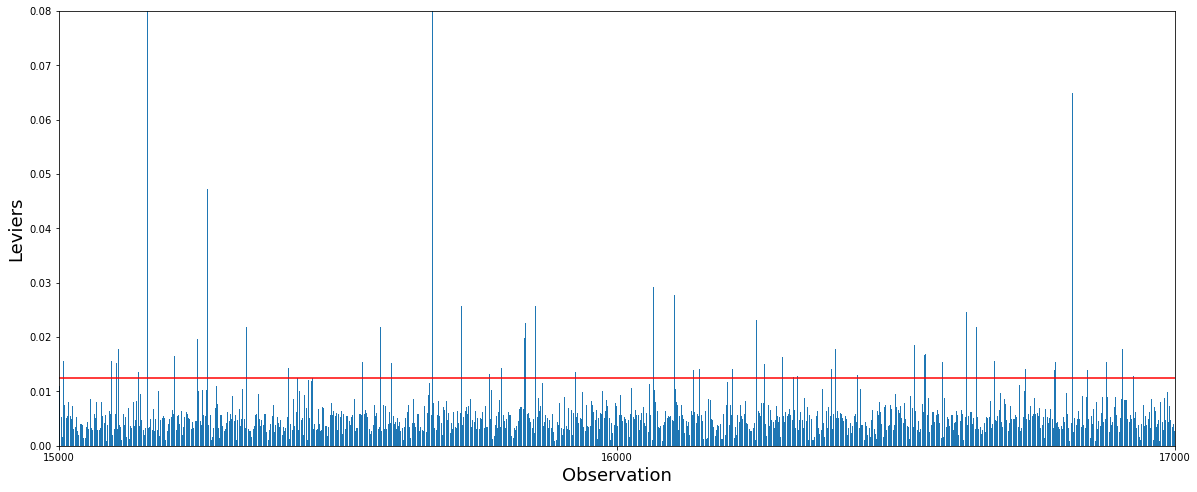

In [77]:
plt.figure(figsize=(20,8))
plt.bar(analyses['obs'], analyses['levier'])
plt.xticks(np.arange(0, n+1, step=1000))
plt.xlabel('Observation',fontsize=18)
plt.ylabel('Leviers',fontsize=18)
plt.xlim([15000,17000])
plt.ylim([0,0.08])
plt.plot([0, n+1], [seuil_levier, seuil_levier], color='r')
plt.show()

### Calcul des résidus studentisés internes : données atypiques sur la variable cible

In [218]:
analyses['rstudent'] = ols_res.get_influence().resid_studentized_internal
seuil_rstudent = t.ppf(1-alpha/2,n-p-1)

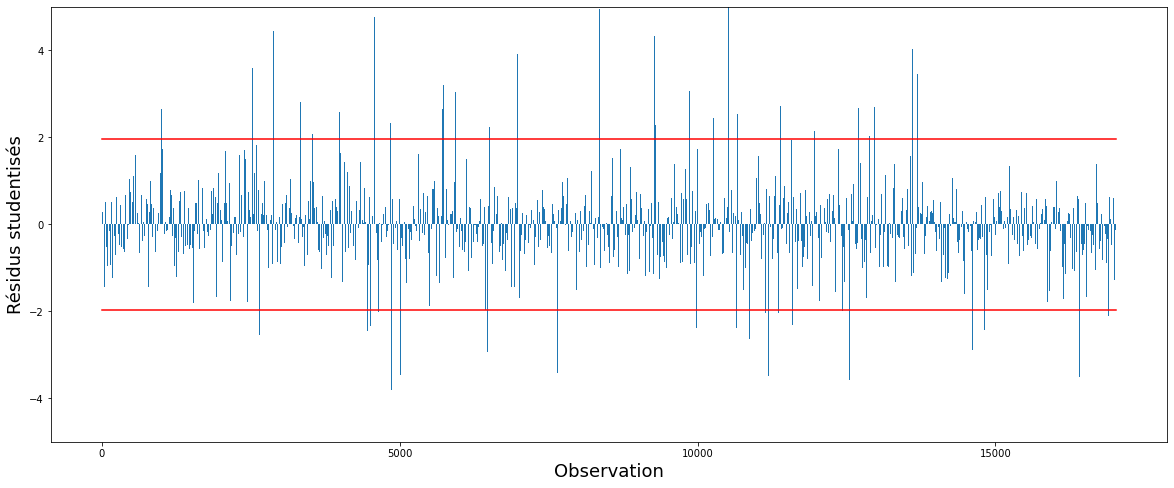

In [79]:
plt.figure(figsize=(20,8))
plt.bar(analyses['obs'], analyses['rstudent'])
plt.xticks(np.arange(0, n+1, step=5000))
plt.xlabel('Observation',fontsize=18)
plt.ylabel('Résidus studentisés',fontsize=18)
plt.ylim([-5,5])
plt.plot([0, n+1], [seuil_rstudent, seuil_rstudent], color='r')
plt.plot([0, n+1], [-seuil_rstudent, -seuil_rstudent], color='r')
plt.show()

### Calcul de la distance de Cook : données influentes

In [219]:
dcooks = pd.DataFrame(ols_res.get_influence().cooks_distance[0],columns=['d_cooks'])
analyses['dcooks'] = dcooks['d_cooks']
seuil_dcook = 4/(n-p)

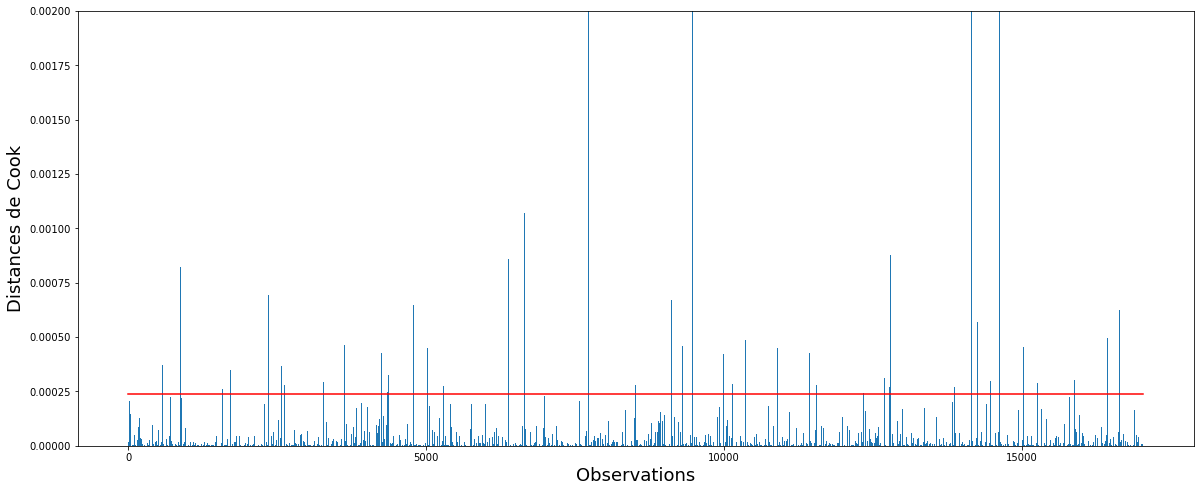

In [82]:
plt.figure(figsize=(20,8))
plt.bar(analyses['obs'], analyses['dcooks'])
plt.xticks(np.arange(0, n+1, step=5000))
plt.xlabel('Observations',fontsize=18)
plt.ylabel('Distances de Cook',fontsize=18)
plt.ylim([0,0.002])
plt.plot([0, n+1], [seuil_dcook, seuil_dcook], color='r')
plt.show()

### Données atypiques et influentes

In [220]:
atypiques_et_influents = analyses.loc[(analyses['levier'] > seuil_levier) &
                                      (analyses['rstudent'] > seuil_rstudent) &
                                      (analyses['dcooks'] > seuil_dcook), :]
atypiques_et_influents_df = df_new.iloc[atypiques_et_influents.index.to_numpy()]

### Suppression des données atypiques et influentes

In [221]:
for row in atypiques_et_influents_df.index:
    df_new = df_new.drop(row)
    X_train_new_df = X_train_new_df.drop(row)
    y_train = y_train.drop(row)

In [ ]:
ols_model = smf.ols(formula, data=df_new)
# ols_model = sm.OLS(y_train,X_train_new)
ols_res = ols_model.fit()
print(ols_res.summary())

In [185]:
variables = ols_res.model.exog
VIF = [variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])] # On ne prend pas en compte la constante
linear_corr_features_idx = [idx+1 for idx, vif in enumerate(VIF) if vif > 20]

C:\Anaconda\envs\mv\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [186]:
name_features_to_delete = X_train_new_df.columns[linear_corr_features_idx]
X_train_new_df = X_train_new_df.drop(X_train_new_df.columns[linear_corr_features_idx],axis=1)
X_test_new_df = X_test_new_df.drop(X_test_new_df.columns[linear_corr_features_idx],axis=1)
df_new = df_new.drop(df_new.columns[linear_corr_features_idx],axis=1)
for feature in name_features_to_delete:
    formula = formula.replace('+' + feature + '+', '+')

In [ ]:
ols_model = smf.ols(formula, data=df_new)
# ols_model = sm.OLS(y_train,X_train_new)
ols_res = ols_model.fit()
print(ols_res.summary())

### Récupération des noms de colonnes originelles

In [213]:
dict_features_name = {}
for i, name in enumerate(X_train.columns):
    dict_features_name[f'x{i}'] = name

In [214]:
columns_poly = X_train_new_df.columns
columns = X_train_new_df.columns
keys = list(dict_features_name.keys())
for i in np.arange(len(dict_features_name)):
    columns = [column.replace(keys[-(i+1)], ' ' + dict_features_name[keys[-(i+1)]]) for column in columns]

dict_features = {}
for i, name in enumerate(columns):
    dict_features[columns_poly[i]] = name

X_train_new_df_rename = X_train_new_df.rename(columns=dict_features)
X_test_new_df_rename = X_test_new_df.rename(columns=dict_features)

In [ ]:
X_train_new_df_rename

### Visualisation des résidus des valeurs prédites

Text(0, 0.5, 'y_test - y-pred')

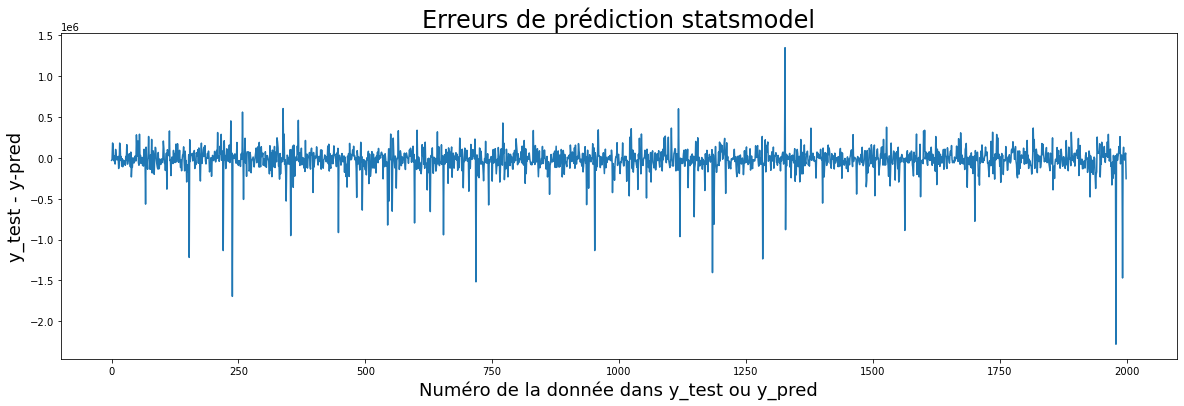

In [164]:
y_pred = ols_res.predict(X_test_new_df)

plt.figure(figsize=(20,6))
interval = 2000
x = np.arange(interval)
plt.plot(x, y_pred[:interval]-y_test['price'][:interval])
plt.title('Erreurs de prédiction statsmodel', fontdict={'fontsize':24})
plt.xlabel('Numéro de la donnée dans y_test ou y_pred',fontsize=18)
plt.ylabel('y_test - y-pred',fontsize=18)

Text(0.5, 0, 'y_test - y_pred')

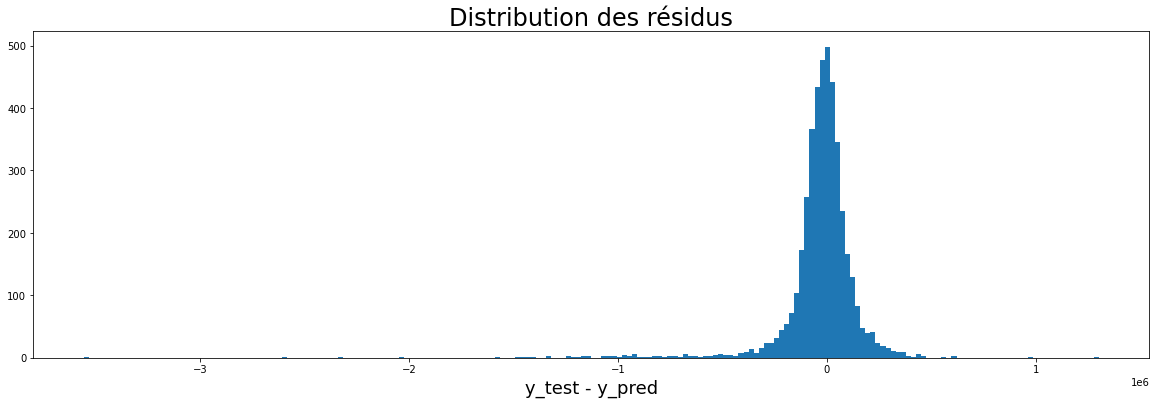

In [91]:
y_pred = ols_res.predict(X_test_new_df)

plt.figure(figsize=(20,6))
plt.hist(y_pred-y_test['price'],bins=200)
plt.title('Distribution des résidus', fontdict={'fontsize':24})
plt.xlabel('y_test - y_pred',fontsize=18)

### Test de normalité des résidus.

In [92]:
shapiro(ols_res.resid)

C:\Anaconda\envs\mv\lib\site-packages\scipy\stats\_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.8737866878509521, pvalue=0.0)

La normalité des erreurs n'est pas respectée. Mais il s'avère que pour des échantillons dont la taille est supérieure à 30, si les erreurs ne vérifient pas l'hypothèse de normalité ça n'a pas d'importance.

In [93]:
test = het_breuschpagan(ols_res.resid, ols_res.model.exog)
names = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
lzip(names, test)

[('Lagrange multiplier statistic', 2276.5863243632784),
 ('p-value', 0.0),
 ('f-value', 25.11669984441911),
 ('f p-value', 0.0)]

La p-value est très petite on rejette donc l'hypothèse nulle d'homoscédasticité. C'est pourtant une hypothèse importante qu'il faut pouvoir vérifier lors d'une régression linéaire. L'hétéroscédasticité ne pose pas de problèmes de biais pour notre estimation mais pose des problèmes d'évaluation de la variance et donc des problèmes pour construire les intervalles de confiance.

## Ajustement sklearn

### Fonctions pour le calcul des métriques

In [223]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error

def adjustedR2(r2,n,k):
    return r2-(k-1)/(n-k)*(1-r2)

def metrics_scores(y, y_pred):
    print('MSE test : ' + str(mean_squared_error(y, y_pred)))
    print('RMSE test : ' + str(np.sqrt(mean_squared_error(y, y_pred))))
    print('MAE test : ' + str(mean_absolute_error(y, y_pred)))
    print('MdAE test : ' + str(median_absolute_error(y, y_pred)))

In [226]:
rlr = Ridge(alpha=0.53)
rlr.fit(X_train_new_df,y_train)
# grid = GridSearchCV(rlr, param_grid = {'alpha': np.linspace(0,2,50)}, scoring='r2', cv=5)
# grid.fit(X_train_new_df,y_train)
# print(grid.best_params_)

metrics = ['r2','neg_mean_squared_error', 'neg_root_mean_squared_error', 'neg_mean_absolute_error','neg_median_absolute_error']
scores = cross_validate(rlr,X_train_new_df,y_train,cv=5,scoring=metrics)

# r2_adj.append(adjustedR2(model.score(X_train,y_train),X_train.shape[0],X_train.shape[1]))
# mse.append(-scores['test_neg_mean_squared_error'].mean())
# rmse.append(-scores['test_neg_root_mean_squared_error'].mean())
# mae.append(-scores['test_neg_mean_absolute_error'].mean())
# mdae.append(-scores['test_neg_median_absolute_error'].mean())
r2 = rlr.score(X_train_new_df,y_train)
print(scores['test_r2'])
print('r2 : ' + str(r2))
print('r2 adj. : ' + str(adjustedR2(r2,X_train_new_df.shape[0],X_train_new_df.shape[1])))
print('MSE : ' + str(-scores['test_neg_mean_squared_error'].mean()))
print('RMSE : ' + str(-scores['test_neg_root_mean_squared_error'].mean()))
print('MAE : ' + str(-scores['test_neg_mean_absolute_error'].mean()))
print('MdAE : ' + str(-scores['test_neg_median_absolute_error'].mean()))
print('------------------------------------------------')

y_pred = rlr.predict(X_test_new_df)

# r2_adj_test.append(adjustedR2(model.score(X_test,y_test),X_test.shape[0],X_test.shape[1]))
# mse_test.append(mean_squared_error(y_test, y_pred))
# rmse_test.append(np.sqrt(mean_squared_error(y_test, y_pred)))
# mae.append(mean_absolute_error(y_test, y_pred))
# mdae.append(median_absolute_error(y_test, y_pred))
r2_test = rlr.score(X_test_new_df,y_test)
print('r2 test : ' + str(r2_test))
print('r2 adj. test: ' + str(adjustedR2(r2_test,X_test_new_df.shape[0],X_test_new_df.shape[1])))
metrics_scores(y_test, y_pred)

# plt.figure(figsize=(20,6))
# interval = 200
# x = np.arange(interval)
# plt.plot(x, y_test[:interval]-y_pred[:interval])
# plt.title('Erreur de prédiction')
# plt.xlabel('Numéro de la donnée dans y_test ou y_pred')
# plt.ylabel('y_test - y-pred')

# plt.figure(figsize=(20,6))
# plt.hist(y_test-y_pred,bins=100)
# plt.title('Distribution des écarts des prédictions par rapport aux données')
# plt.xlabel('y_test - y_pred')

[0.83147274 0.83957604 0.84861401 0.85595722 0.85236646]
r2 : 0.8501957891888402
r2 adj. : 0.8492238378387619
MSE : 13732030391.40484
RMSE : 117119.95464412076
MAE : 76894.57651936964
MdAE : 52662.958311616174
------------------------------------------------
r2 test : 0.8203857619379233
r2 adj. test: 0.8156949817416203
MSE test : 27153489984.745106
RMSE test : 164783.16050114195
MAE test : 93567.98612295803
MdAE test : 58837.820094434894


### Learning curve

In [227]:
N, train_score, val_score = learning_curve(rlr, X_train_new_df, y_train, train_sizes=np.linspace(0.1,1,20))

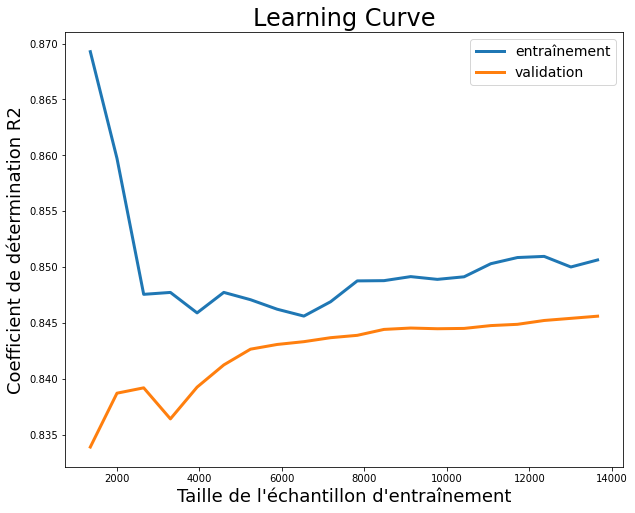

In [228]:
plt.figure(figsize=(10,8))
plt.plot(N,train_score.mean(axis=1),lw=3,label='entraînement')
plt.plot(N,val_score.mean(axis=1),lw=3,label='validation')
plt.title('Learning Curve',fontsize=24)
plt.xlabel('Taille de l\'échantillon d\'entraînement',fontsize=18)
plt.ylabel('Coefficient de détermination R2',fontsize=18)
plt.legend(fontsize=14)